# Multi-Year Analysis

In [9]:
from config import config
import parser
import os
import sys
import geojson
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
years = [2010,2014,2018]

# Parse census data:
with open('nst-est2019-alldata.csv') as censusCSV:
    census = list(csv.reader(censusCSV))
    header = census[0]

def grabCensusYear(year): 
    index_check = []
    for i, item in enumerate(header):
        if str(year) in item:
            index_check.append(i)
            break
    return index_check[0] # just for POPESTIMATE2018 (Population Estimate; might need some other fields later)
    
yearPop = []
for year in years:
    _in = grabCensusYear(year)
    popEst = pd.DataFrame([(int(census[y][3]),census[y][4], int(census[y][_in])) for y in range(1,len(census)) if int(census[y][3]) > 0])
    yearPop.append(popEst)
    print("Estimated Population")
    print(popEst[:10])
    print("...")

Estimated Population
    0                     1         2
0   1               Alabama   4779736
1   2                Alaska    710231
2   4               Arizona   6392017
3   5              Arkansas   2915918
4   6            California  37253956
5   8              Colorado   5029196
6   9           Connecticut   3574097
7  10              Delaware    897934
8  11  District of Columbia    601723
9  12               Florida  18801310
...
Estimated Population
    0                     1         2
0   1               Alabama   4841799
1   2                Alaska    736283
2   4               Arizona   6730413
3   5              Arkansas   2967392
4   6            California  38596972
5   8              Colorado   5350101
6   9           Connecticut   3594524
7  10              Delaware    932487
8  11  District of Columbia    662328
9  12               Florida  19845911
...
Estimated Population
    0                     1         2
0   1               Alabama   4887681
1   2            

In [5]:
# import cartopy stuff:
us_shapes = list(shpreader.Reader('shapes/gadm36_USA_1.shp').geometries())
year_accidents = []

# import parser data:
for year in years:
    fars_years = parser.generateFARS(year)
    fars_2018_files = parser.grabFiles(fars_years)
    enum = list(enumerate(fars_2018_files))
    enum = list(map(str.lower,[i[1] for i in enum]))
    index = enum.index('accident.csv')
    print("Reading file: ", fars_2018_files[index])

    category = parser.grabCat(fars_2018_files)
    cat = category[index]
    accidents = parser.csvRead(os.path.join(parser.ROOT, fars_years, fars_2018_files[index]), cat)
    year_accidents.append(accidents)

Reading file:  ACCIDENT.CSV
Reading file:  ACCIDENT.csv
Reading file:  ACCIDENT.csv


In [8]:
# Show example rows of ACCIDENT.csv
example = random.choices(year_accidents[0], k=5)
df = pd.DataFrame(example)
df.style

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PEDS,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,ROAD_FNC,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,REL_ROAD,WRK_ZONE,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,8,80174,1,1,0,1,1,0,3,7,2010,7,6,27,1,11,1,I-25 RAMP E,,2170,39.826775,-104.984156,0,24,0,1,5,1,4,0,4,1,0,1,0,0000000,6,27,6,34,88,88,0,0,0,1,1
1,24,240446,1,1,0,1,41,0,31,12,2010,6,22,6,0,6,3,SR-565,,26,38.692042,-76.062597,0,42,0,0,1,1,6,0,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,1
2,51,510213,1,1,0,5,99,0,9,5,2010,1,0,51,0,4,3,SR-218,,158,38.190233,-77.114411,0,30,0,0,1,1,4,0,2,1,0,1,0,0000000,99,99,99,99,99,99,0,0,0,1,0
3,48,480839,2,2,0,9,7,0,29,5,2010,7,16,58,1,1,1,I-45,,181,31.346944,-96.012581,0,1,0,0,1,1,3,0,1,1,0,1,0,0000000,17,5,17,44,18,41,0,0,0,3,0
4,6,62108,1,1,0,1,55,0,4,11,2010,5,2,5,0,4,4,SILVERADO TRAIL,,0,38.443181,-122.352461,0,42,0,0,1,1,4,0,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,0


In [20]:
def accidentAmount(accidents): 
    # List coordinates:
    print('Number of accidents in 2018 US:', len(accidents))
    accident_tuples = []
    for item in accidents:
        if item['LATITUDE'] != 99.9999 and item['LONGITUD'] != 777.7777:
            accident_tuples.append( (item['LATITUDE'], item['LONGITUD']) )
    return accident_tuples

def generateMapBounds(accident_tuples):
    max_lng, min_lng = -10000,10000
    max_lat, min_lat = 0,10000

    for acc in accident_tuples:
        if max_lng <= acc[1]:
            max_lng = acc[1]
        if min_lng >= acc[1]:
            min_lng = acc[1]

        if max_lat <= acc[0]:
            max_lat = acc[0]
        if min_lat >= acc[0]:
            min_lat = acc[0]

    regular_lat = max_lat-min_lat
    regular_lng = max_lng+(abs(min_lng))

    print("regular_lat: ", regular_lat, "regular_lng: ", regular_lng)
    print("max_lng: ", max_lng, "min_lng: ", min_lng)
    print("max_lat: ", max_lat, "min_lat: ", min_lat)
    extent = [max_lng, min_lng,max_lat,min_lat] #y1,y2,x1,x2
    return (extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng)

def generateMap(accident_tuples, extent, year):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.imshow(imread('shapes/NE1_50M_SR_W.tif'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    ax.add_geometries(us_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    #ax.add_feature(cfeature.BORDERS)
    ax.set_extent(extent)

    #heat_data = np.random.normal(0.0,1.0,size=(400,200))
    heat_data = np.zeros((600,300))

    for item in accident_tuples:
        _lat, _lon = \
                        heat_data.shape[1]*((max_lat-item[0])/regular_lat), \
                        heat_data.shape[0]*((abs(item[1])-abs(max_lng))/regular_lng)
        if heat_data[int(_lon)-1][int(_lat)-1] <= 10:
            heat_data[int(_lon)-1][int(_lat)-1] += 1

    lat = np.linspace(extent[0],extent[1],heat_data.shape[0])
    lon = np.linspace(extent[2],extent[3],heat_data.shape[1])
    print(heat_data.shape, lat.shape, lon.shape)
    Lat,Lon = np.meshgrid(lat,lon)
    print(Lat.shape)
    ax.pcolormesh(Lat,Lon,np.transpose(heat_data), alpha=0.5)
    plt.title('Heatmap of Accidents within the United States - %i'%(year))
    return plt

In [19]:
'''
for year_acc, yr in zip(year_accidents, years):
    acc_tuple = accidentAmount(year_acc)
    extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng = generateMapBounds(acc_tuple)
    _map = generateMap(acc_tuple, extent, yr)
'''

'\nfor year_acc in year_accidents:\n    acc_tuple = accidentAmount(year_acc)\n    extent, max_lat, min_lat, max_lng, min_lng, regular_lat, regular_lng = generateMapBounds(acc_tuple)\n    _map = generateMap(acc_tuple, extent)\n'

In [21]:
def generateGraphData(accidents):
    # Graphing accidents per state:
    INTERSTATE_PREFIXES = ['I-']
    HIGHWAY_PREFIXES = ['HWY', 'US-']

    def checkIfPrefix(word, list_fix):
        for fix in list_fix:
            if fix in word:
                return True
        return False

    state_dict = {}
    for state in accidents:
        if state['STATE'] > 0:
            if checkIfPrefix(state['TWAY_ID'], INTERSTATE_PREFIXES):
                if state['STATE'] in state_dict:
                    state_dict[state['STATE']] += 1
                else:
                    state_dict[state['STATE']] = 1
            else:
                if not state['STATE'] in state_dict: 
                    state_dict[state['STATE']] = 0
    # temp:
    state_dict[72] = 0
    INTER_X, INTER_Y, TOTAL_Y = [], [], []

    for item, row in popEst.iterrows():
        INTER_X.append(row[1])
        INTER_Y.append((state_dict[row[0]]/row[2])*(10**5))
        TOTAL_Y.append(state_dict[row[0]])

    # sort it:
    _INTER_X, _INTER_Y = [], []
    INTER_COM = sorted(zip(INTER_Y,INTER_X))
    for y,x in INTER_COM:
        _INTER_X.append(x)
        _INTER_Y.append(y)
    return _INTER_X, _INTER_Y, TOTAL_Y

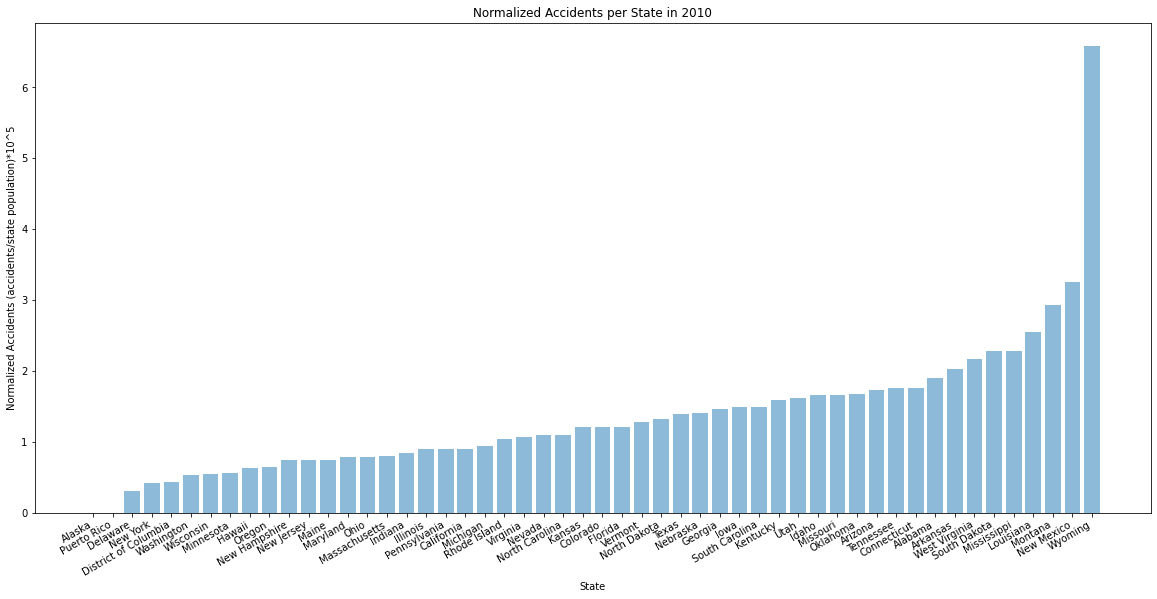

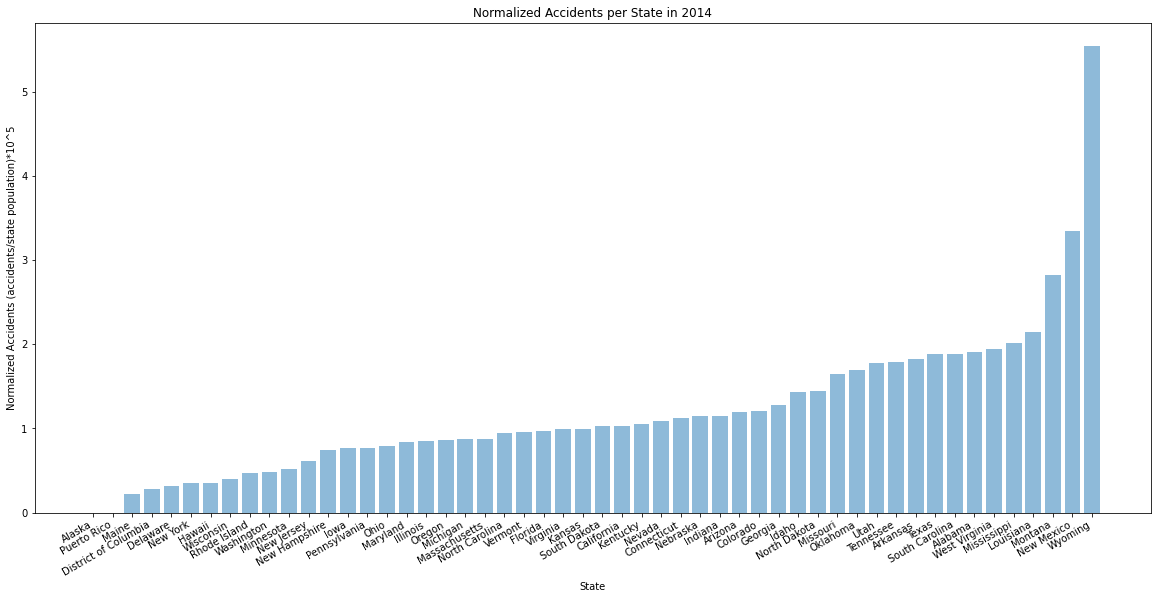

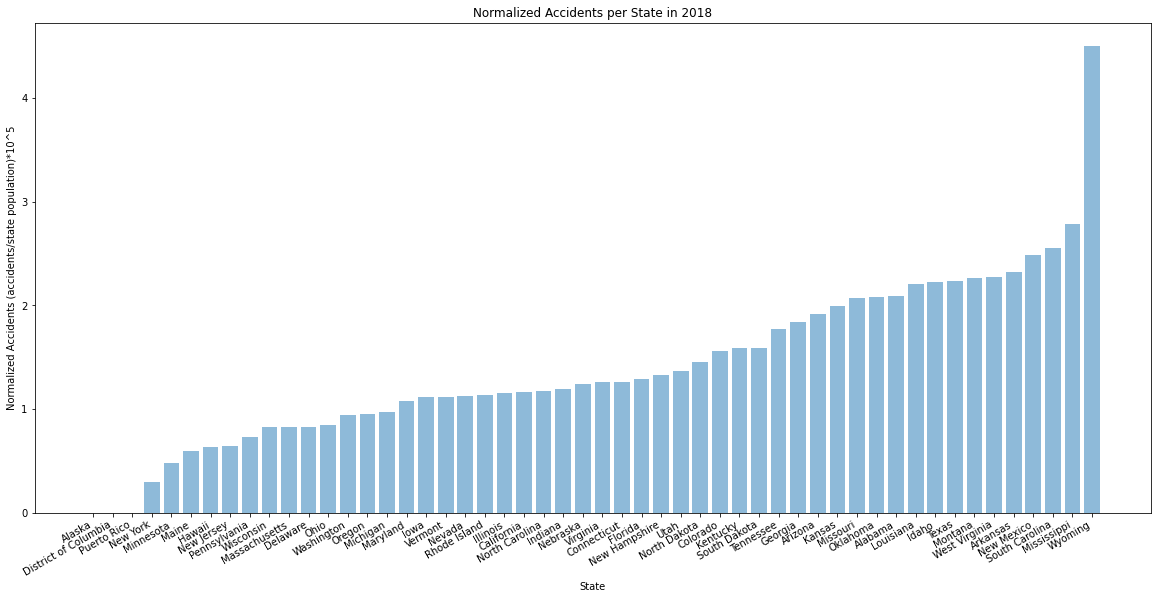

In [22]:
for accident, yr in zip(year_accidents, years):
    _INTER_X, _INTER_Y, TOTAL_Y = generateGraphData(accident)
    fig,ax = plt.subplots(figsize=(20,10))
    plt.bar(_INTER_X,_INTER_Y, align='center', alpha=0.5)
    plt.xticks(rotation=45)
    plt.title('Normalized Accidents per State in %i'%yr)
    fig.autofmt_xdate()
    ax.set_xlabel('State')
    ax.set_ylabel('Normalized Accidents (accidents/state population)*10^5')
    plt.show()

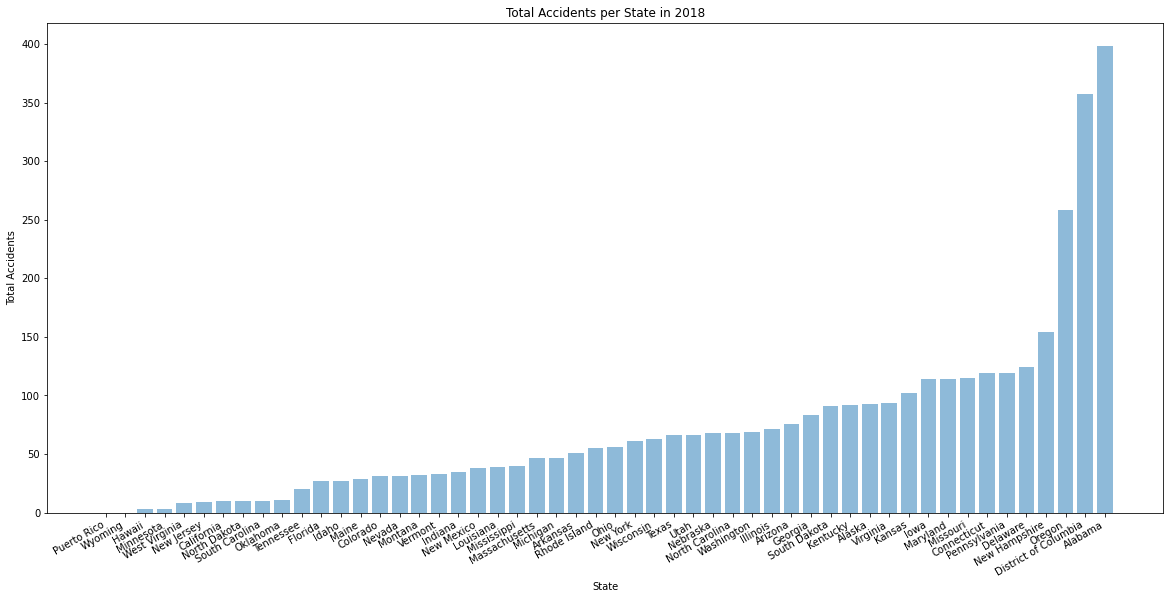

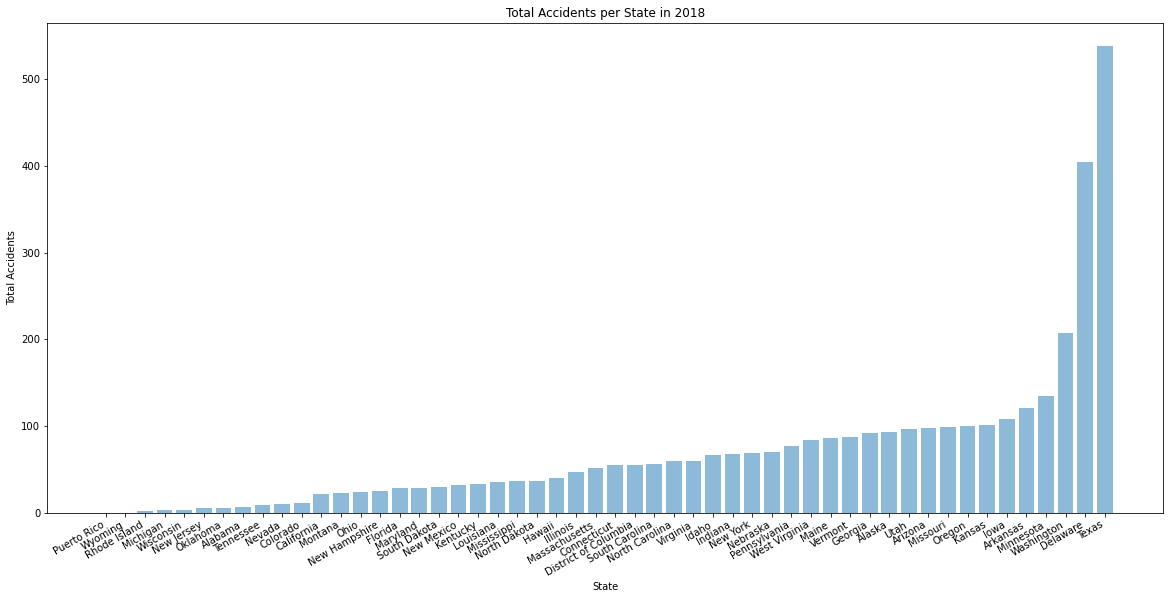

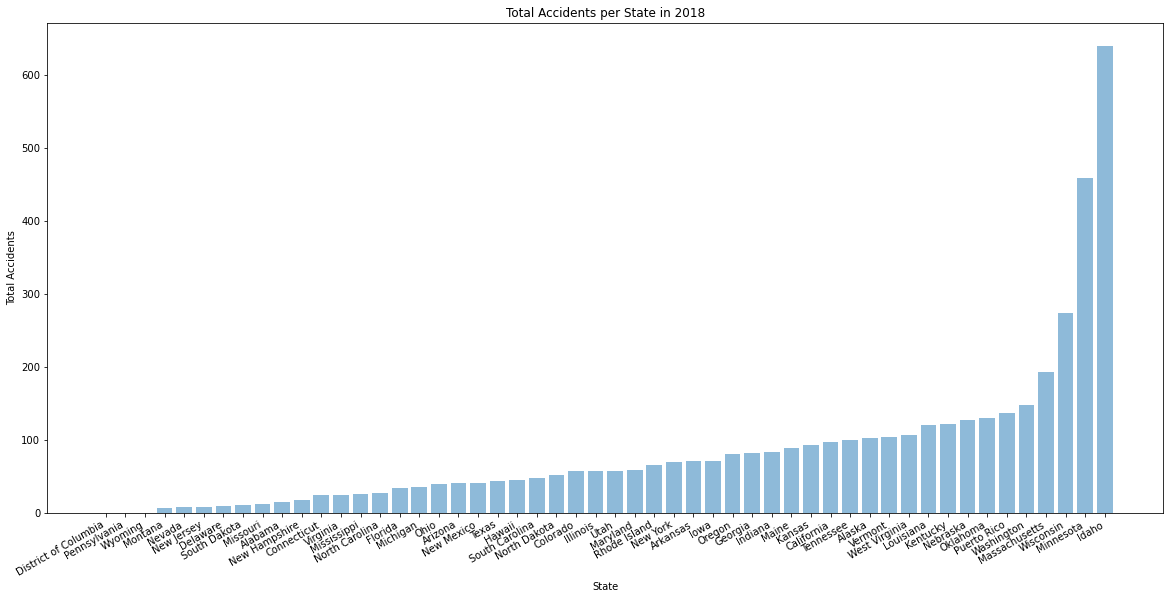

In [23]:
for accident, yr in zip(year_accidents, years):
    INTER_X, INTER_Y, TOTAL_Y = generateGraphData(accident)
    _INTER_X, _INTER_Y = [], []
    INTER_COM = sorted(zip(TOTAL_Y,INTER_X))
    for y,x in INTER_COM:
        _INTER_X.append(x)
        _INTER_Y.append(y)
    fig,ax = plt.subplots(figsize=(20,10))
    plt.bar(_INTER_X,_INTER_Y, align='center', alpha=0.5)
    plt.xticks(rotation=45)
    plt.title('Total Accidents per State in %i'%2018)
    fig.autofmt_xdate()
    ax.set_xlabel('State')
    ax.set_ylabel('Total Accidents')
    plt.show()